In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from scipy.optimize import minimize
from scipy import stats
from typing import List, Dict, Tuple
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
class DataRetriever:
    BASE_URL = 'https://api.exchange.coinbase.com'

    @staticmethod
    def fetch_orderbook(product_id: str = 'BTC-USD', level: int = 2) -> dict:
        url = f'{DataRetriever.BASE_URL}/products/{product_id}/book'
        response = requests.get(url, params={'level': level})
        response.raise_for_status()
        return response.json()

    @staticmethod
    def fetch_trades(product_id: str = 'BTC-USD', limit: int = 1000) -> pd.DataFrame:
        url = f'{DataRetriever.BASE_URL}/products/{product_id}/trades'
        response = requests.get(url, params={'limit': limit})
        response.raise_for_status()

        trades = response.json()
        df = pd.DataFrame(trades)
        df['time'] = pd.to_datetime(df['time'])
        df['price'] = df['price'].astype(float)
        df['size'] = df['size'].astype(float)
        df = df.sort_values('time').reset_index(drop=True)
        df['interarrival'] = df['time'].diff().dt.total_seconds().fillna(0)

        return df

    @staticmethod
    def fetch_candles(product_id: str = 'BTC-USD', granularity: int = 300, max_candles: int = 300) -> pd.DataFrame:
        url = f'{DataRetriever.BASE_URL}/products/{product_id}/candles'
        end_time = datetime.now(timezone.utc)
        time_window_seconds = granularity * max_candles
        start_time = end_time - timedelta(seconds=time_window_seconds)

        params = {
            'start': int(start_time.timestamp()),
            'end': int(end_time.timestamp()),
            'granularity': granularity
        }

        response = requests.get(url, params=params)
        response.raise_for_status()
        candles = response.json()

        if not candles:
            return None

        df = pd.DataFrame(candles, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df = df.sort_values('time').reset_index(drop=True)
        df['returns'] = np.log(df['close'] / df['close'].shift(1))

        return df


def compute_market_summary(trades_df: pd.DataFrame, orderbook: dict) -> pd.DataFrame:
    best_bid = float(orderbook['bids'][0][0])
    best_ask = float(orderbook['asks'][0][0])
    mid_price = (best_bid + best_ask) / 2
    spread = best_ask - best_bid
    time_span_hours = (trades_df['time'].max() - trades_df['time'].min()).total_seconds() / 3600

    summary = pd.DataFrame({
        'Metric': [
            'Product', 'Total Trades', 'Time Span (hours)', 'Start Time', 'End Time',
            'Current Mid', 'Current Spread', 'Avg Size', 'Total Volume', 'Avg Price', 'Price Std'
        ],
        'Value': [
            'BTC-USD', f"{len(trades_df):,}", f"{time_span_hours:.2f}",
            trades_df['time'].min().strftime('%Y-%m-%d %H:%M:%S'),
            trades_df['time'].max().strftime('%Y-%m-%d %H:%M:%S'),
            f"${mid_price:,.2f}", f"${spread:.2f}", f"{trades_df['size'].mean():.4f}",
            f"{trades_df['size'].sum():.2f}", f"${trades_df['price'].mean():,.2f}",
            f"${trades_df['price'].std():.2f}"
        ]
    })
    return summary

In [3]:
orderbook = DataRetriever.fetch_orderbook('BTC-USD')
trades_df = DataRetriever.fetch_trades('BTC-USD', limit=1000)
candles_df = DataRetriever.fetch_candles('BTC-USD', granularity=300, max_candles=300)

market_summary = compute_market_summary(trades_df, orderbook)
display(market_summary)

if candles_df is not None and len(candles_df) > 1:
    volatility = candles_df['returns'].std()
else:
    trades_df['log_return'] = np.log(trades_df['price'] / trades_df['price'].shift(1))
    volatility = trades_df['log_return'].std()

,Metric,Value
0,Product,BTC-USD
1,Total Trades,"1,000"
2,Time Span (hours),0.06
3,Start Time,2025-11-08 11:50:32
4,End Time,2025-11-08 11:53:50
5,Current Mid,"$101,886.02"
6,Current Spread,$0.01
7,Avg Size,0.0134
8,Total Volume,13.44
9,Avg Price,"$101,935.35"


In [4]:
class HawkesCalibrator:
    @staticmethod
    def calibrate_mle(interarrival_times: np.ndarray, max_samples: int = 3000) -> Tuple[float, float, float]:
        tau = interarrival_times[interarrival_times > 0]

        if len(tau) > max_samples:
            tau = np.random.choice(tau, size=max_samples, replace=False)

        mu0 = 1.0 / np.mean(tau)
        cv = np.std(tau) / np.mean(tau)
        alpha0 = min(0.8, max(0.1, cv - 1.0))
        beta0 = 2.0 * mu0

        def neg_log_likelihood(params):
            mu, alpha, beta = params
            if mu <= 0 or alpha <= 0 or alpha >= 1 or beta <= 0:
                return 1e10

            n = len(tau)
            T = np.sum(tau)
            lambda_t = np.zeros(n)
            lambda_t[0] = mu

            for i in range(1, n):
                lambda_t[i] = mu + alpha * np.sum(
                    beta * np.exp(-beta * np.sum(tau[j:i])) for j in range(i)
                )

            ll = np.sum(np.log(lambda_t + 1e-10)) - mu * T - (alpha / beta) * n
            return -ll

        result = minimize(
            neg_log_likelihood,
            [mu0, alpha0, beta0],
            method='L-BFGS-B',
            bounds=[(1e-6, None), (1e-6, 0.99), (1e-6, None)]
        )

        return tuple(result.x) if result.success else (mu0, alpha0, beta0)

In [5]:
mu, alpha, beta = HawkesCalibrator.calibrate_mle(trades_df['interarrival'].values)

hawkes_params = {'mu': mu, 'alpha': alpha, 'beta': beta}
as_params = {'sigma': volatility, 'gamma': 0.1, 'T': 1.0, 'k': 1.5}

calib_results = pd.DataFrame({
    'Model': ['Hawkes', 'Hawkes', 'Hawkes', 'AS', 'AS', 'AS', 'AS'],
    'Parameter': ['μ', 'α', 'β', 'σ', 'γ', 'T', 'k'],
    'Value': [
        f"{mu:.6f}", f"{alpha:.6f}", f"{beta:.6f}",
        f"{volatility:.6f}", f"{as_params['gamma']:.2f}",
        f"{as_params['T']:.2f}", f"{as_params['k']:.2f}"
    ]
})

display(calib_results)

,Model,Parameter,Value
0,Hawkes,μ,1.775934
1,Hawkes,α,0.990000
2,Hawkes,β,172.850626
3,AS,σ,0.001624
4,AS,γ,0.10
5,AS,T,1.00
6,AS,k,1.50


In [6]:
class HawkesMarketMaker:
    def __init__(self, mu: float, alpha: float, beta: float, spread_multiplier: float = 5.0):
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.spread_multiplier = spread_multiplier
        self.event_times = []

    def intensity(self, t: float) -> float:
        if not self.event_times:
            return self.mu

        excitation = sum(
            self.alpha * self.beta * np.exp(-self.beta * (t - ti))
            for ti in self.event_times if ti < t
        )
        return self.mu + excitation

    def get_quotes(self, mid_price: float, current_time: float, inventory: float) -> Tuple[float, float]:
        lambda_t = self.intensity(current_time)
        base_spread = self.spread_multiplier / max(lambda_t, 0.1)
        inventory_skew = inventory * mid_price * 0.0002

        bid = mid_price - base_spread / 2 + inventory_skew
        ask = mid_price + base_spread / 2 + inventory_skew

        return bid, ask

    def record_event(self, event_time: float):
        self.event_times.append(event_time)
        if len(self.event_times) > 100:
            self.event_times = self.event_times[-100:]


class AvellanedaStoikovMM:
    def __init__(self, sigma: float, gamma: float, T: float, k: float):
        self.sigma = sigma
        self.gamma = gamma
        self.T = T
        self.k = k

    def reservation_price(self, mid_price: float, inventory: float, t: float) -> float:
        time_left = max(self.T - t, 0.01)
        return mid_price - inventory * self.gamma * (self.sigma ** 2) * time_left

    def optimal_spread(self, t: float) -> float:
        time_left = max(self.T - t, 0.01)
        return (self.gamma * (self.sigma ** 2) * time_left +
                (2 / self.gamma) * np.log(1 + self.gamma / self.k)) / 1000

    def get_quotes(self, mid_price: float, inventory: float, t: float) -> Tuple[float, float]:
        r = self.reservation_price(mid_price, inventory, t)
        delta = self.optimal_spread(t) / 2
        return r - delta, r + delta

In [7]:
class BacktestEngine:
    def __init__(self, trades_df: pd.DataFrame, initial_cash: float = 100000,
                 position_limit: float = 1.0, trade_size: float = 0.01):
        self.trades_df = trades_df.copy()
        self.initial_cash = initial_cash
        self.position_limit = position_limit
        self.trade_size = trade_size
        self.maker_fee = -0.0001

    def run_strategy(self, strategy, strategy_name: str) -> Dict:
        cash = self.initial_cash
        inventory = 0.0
        pnl_history = []
        inventory_history = []
        filled_count = 0

        start_time = self.trades_df['time'].iloc[0]
        self.trades_df['norm_time'] = (
            (self.trades_df['time'] - start_time).dt.total_seconds() / 3600
        )

        mid_price_series = self.trades_df['price'].rolling(window=10, min_periods=1).mean()
        fill_tolerance = 0.5

        for idx, trade in self.trades_df.iterrows():
            market_price = trade['price']
            trade_side = trade['side']
            t = trade['norm_time']
            current_mid = mid_price_series.iloc[idx]

            if isinstance(strategy, HawkesMarketMaker):
                bid, ask = strategy.get_quotes(current_mid, t, inventory)
                strategy.record_event(t)
            else:
                bid, ask = strategy.get_quotes(current_mid, inventory, t)

            if (trade_side == 'buy' and abs(market_price - ask) < fill_tolerance and
                inventory > -self.position_limit):
                inventory -= self.trade_size
                cash += ask * self.trade_size * (1 + self.maker_fee)
                filled_count += 1

            elif (trade_side == 'sell' and abs(market_price - bid) < fill_tolerance and
                  inventory < self.position_limit):
                inventory += self.trade_size
                cash -= bid * self.trade_size * (1 - self.maker_fee)
                filled_count += 1

            pnl = cash + inventory * market_price - self.initial_cash
            pnl_history.append(pnl)
            inventory_history.append(inventory)

        return self._compute_metrics(strategy_name, pnl_history, inventory_history, filled_count)

    def _compute_metrics(self, strategy_name: str, pnl_history: List[float],
                        inventory_history: List[float], filled_count: int) -> Dict:
        pnl_series = pd.Series(pnl_history)
        pnl_changes = pnl_series.diff().fillna(0)

        final_pnl = pnl_series.iloc[-1]
        total_return = final_pnl / self.initial_cash

        if pnl_changes.std() > 0:
            sharpe = (pnl_changes.mean() / pnl_changes.std()) * np.sqrt(252)
        else:
            sharpe = 0

        cummax = pnl_series.cummax()
        drawdown = cummax - pnl_series
        max_dd = drawdown.max()
        max_dd_pct = (max_dd / (self.initial_cash + cummax.max())) * 100 if cummax.max() > 0 else 0

        avg_abs_inv = np.mean(np.abs(inventory_history))
        max_abs_inv = max(abs(min(inventory_history)), abs(max(inventory_history)))

        return {
            'strategy': strategy_name,
            'final_pnl': final_pnl,
            'total_return': total_return,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'max_drawdown_pct': max_dd_pct,
            'num_fills': filled_count,
            'fill_rate': filled_count / len(self.trades_df),
            'avg_abs_inventory': avg_abs_inv,
            'max_abs_inventory': max_abs_inv,
            'pnl_history': pnl_history,
            'inventory_history': inventory_history
        }

In [8]:
hawkes_mm = HawkesMarketMaker(mu=hawkes_params['mu'], alpha=hawkes_params['alpha'],
                               beta=hawkes_params['beta'], spread_multiplier=5.0)

as_mm = AvellanedaStoikovMM(sigma=as_params['sigma'], gamma=as_params['gamma'] * 0.01,
                             T=as_params['T'], k=as_params['k'])

engine = BacktestEngine(trades_df, initial_cash=100000, position_limit=0.5, trade_size=0.01)

hawkes_results = engine.run_strategy(hawkes_mm, 'Hawkes')
as_results = engine.run_strategy(as_mm, 'AS')

results_comparison = pd.DataFrame([
    {
        'Strategy': 'Hawkes',
        'Final PnL': f"${hawkes_results['final_pnl']:.2f}",
        'Return (%)': f"{hawkes_results['total_return']*100:.2f}",
        'Sharpe': f"{hawkes_results['sharpe_ratio']:.2f}",
        'Max DD': f"${hawkes_results['max_drawdown']:.2f}",
        'Max DD (%)': f"{hawkes_results['max_drawdown_pct']:.2f}",
        'Fills': hawkes_results['num_fills'],
        'Fill Rate (%)': f"{hawkes_results['fill_rate']*100:.2f}",
        'Avg |Inv|': f"{hawkes_results['avg_abs_inventory']:.4f}"
    },
    {
        'Strategy': 'AS',
        'Final PnL': f"${as_results['final_pnl']:.2f}",
        'Return (%)': f"{as_results['total_return']*100:.2f}",
        'Sharpe': f"{as_results['sharpe_ratio']:.2f}",
        'Max DD': f"${as_results['max_drawdown']:.2f}",
        'Max DD (%)': f"{as_results['max_drawdown_pct']:.2f}",
        'Fills': as_results['num_fills'],
        'Fill Rate (%)': f"{as_results['fill_rate']*100:.2f}",
        'Avg |Inv|': f"{as_results['avg_abs_inventory']:.4f}"
    }
])

display(results_comparison)

,Strategy,Final PnL,Return (%),Sharpe,Max DD,Max DD (%),Fills,Fill Rate (%),Avg |Inv|
0,Hawkes,$14.06,0.01,0.45,$18.22,0.02,68,6.80,0.1581
1,AS,$15.94,0.02,0.23,$39.75,0.04,115,11.50,0.3572


In [9]:
def plot_pnl_comparison(hawkes_results: Dict, as_results: Dict):
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(hawkes_results['pnl_history'], label='Hawkes', linewidth=2)
    ax.plot(as_results['pnl_history'], label='AS', linewidth=2)
    ax.set_xlabel('Trade')
    ax.set_ylabel('PnL ($)')
    ax.set_title('Cumulative PnL', fontweight='bold', fontsize=14)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_drawdown_comparison(hawkes_results: Dict, as_results: Dict):
    hawkes_pnl = pd.Series(hawkes_results['pnl_history'])
    as_pnl = pd.Series(as_results['pnl_history'])
    hawkes_dd = hawkes_pnl.cummax() - hawkes_pnl
    as_dd = as_pnl.cummax() - as_pnl

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.fill_between(range(len(hawkes_dd)), 0, hawkes_dd, alpha=0.5, label='Hawkes')
    ax.fill_between(range(len(as_dd)), 0, as_dd, alpha=0.5, label='AS')
    ax.set_xlabel('Trade')
    ax.set_ylabel('Drawdown ($)')
    ax.set_title('Drawdown Comparison', fontweight='bold', fontsize=14)
    ax.legend()
    ax.grid(alpha=0.3)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


def plot_inventory_evolution(hawkes_results: Dict, as_results: Dict):
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(hawkes_results['inventory_history'], label='Hawkes', linewidth=2)
    ax.plot(as_results['inventory_history'], label='AS', linewidth=2)
    ax.set_xlabel('Trade')
    ax.set_ylabel('Inventory (BTC)')
    ax.set_title('Inventory Evolution', fontweight='bold', fontsize=14)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_returns_distribution(hawkes_results: Dict, as_results: Dict):
    hawkes_returns = pd.Series(hawkes_results['pnl_history']).diff().dropna()
    as_returns = pd.Series(as_results['pnl_history']).diff().dropna()

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.hist(hawkes_returns, bins=30, alpha=0.6, label='Hawkes', density=True)
    ax.hist(as_returns, bins=30, alpha=0.6, label='AS', density=True)
    ax.set_xlabel('PnL Change ($)')
    ax.set_ylabel('Density')
    ax.set_title('Returns Distribution', fontweight='bold', fontsize=14)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_qq_plots(hawkes_results: Dict, as_results: Dict):
    hawkes_returns = pd.Series(hawkes_results['pnl_history']).diff().dropna()
    as_returns = pd.Series(as_results['pnl_history']).diff().dropna()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    stats.probplot(hawkes_returns, dist="norm", plot=axes[0])
    axes[0].set_title('Q-Q Plot: Hawkes', fontweight='bold', fontsize=12)
    axes[0].grid(alpha=0.3)

    stats.probplot(as_returns, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot: AS', fontweight='bold', fontsize=12)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_performance_metrics(hawkes_results: Dict, as_results: Dict):
    metrics = ['Final PnL', 'Sharpe', 'Max DD', 'Fills']
    hawkes_vals = [
        hawkes_results['final_pnl'],
        hawkes_results['sharpe_ratio'],
        -hawkes_results['max_drawdown'],
        hawkes_results['num_fills']
    ]
    as_vals = [
        as_results['final_pnl'],
        as_results['sharpe_ratio'],
        -as_results['max_drawdown'],
        as_results['num_fills']
    ]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, (metric, h_val, a_val) in enumerate(zip(metrics, hawkes_vals, as_vals)):
        axes[i].bar(['Hawkes', 'AS'], [h_val, a_val], color=['#2E86AB', '#A23B72'])
        axes[i].set_title(metric, fontsize=12, fontweight='bold')
        axes[i].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


def compute_normality_tests(hawkes_results: Dict, as_results: Dict) -> pd.DataFrame:
    hawkes_returns = pd.Series(hawkes_results['pnl_history']).diff().dropna()
    as_returns = pd.Series(as_results['pnl_history']).diff().dropna()

    hawkes_stat, hawkes_p = stats.shapiro(hawkes_returns)
    as_stat, as_p = stats.shapiro(as_returns)

    normality_results = pd.DataFrame({
        'Strategy': ['Hawkes', 'AS'],
        'Shapiro Stat': [f"{hawkes_stat:.4f}", f"{as_stat:.4f}"],
        'p-value': [f"{hawkes_p:.4f}", f"{as_p:.4f}"],
        'Normal?': ['Yes' if hawkes_p > 0.05 else 'No', 'Yes' if as_p > 0.05 else 'No']
    })

    return normality_results

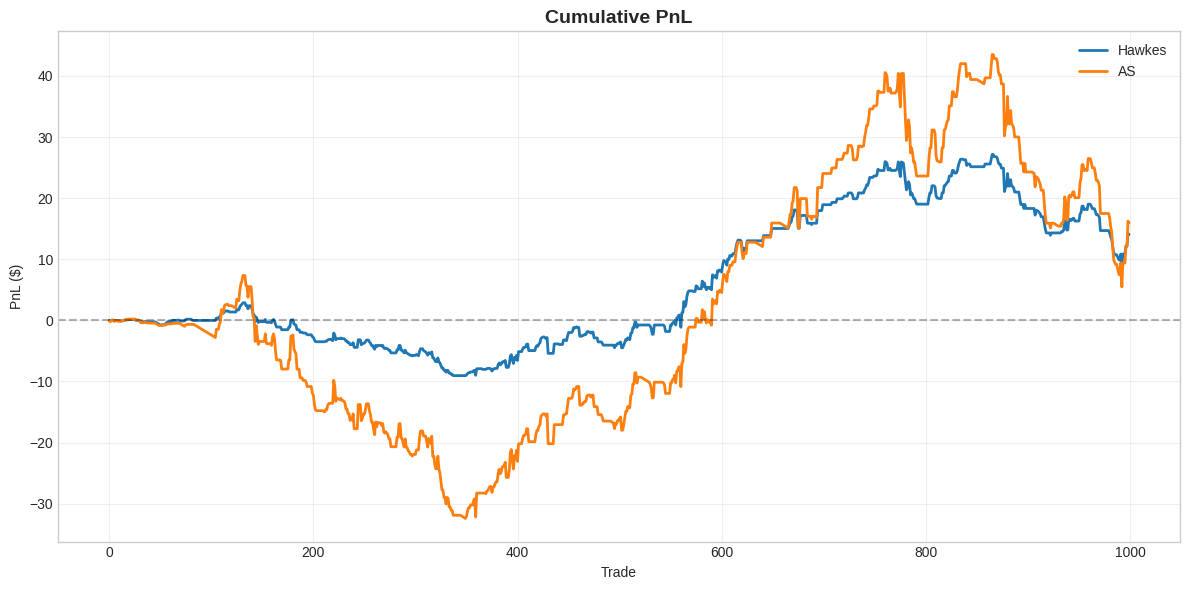

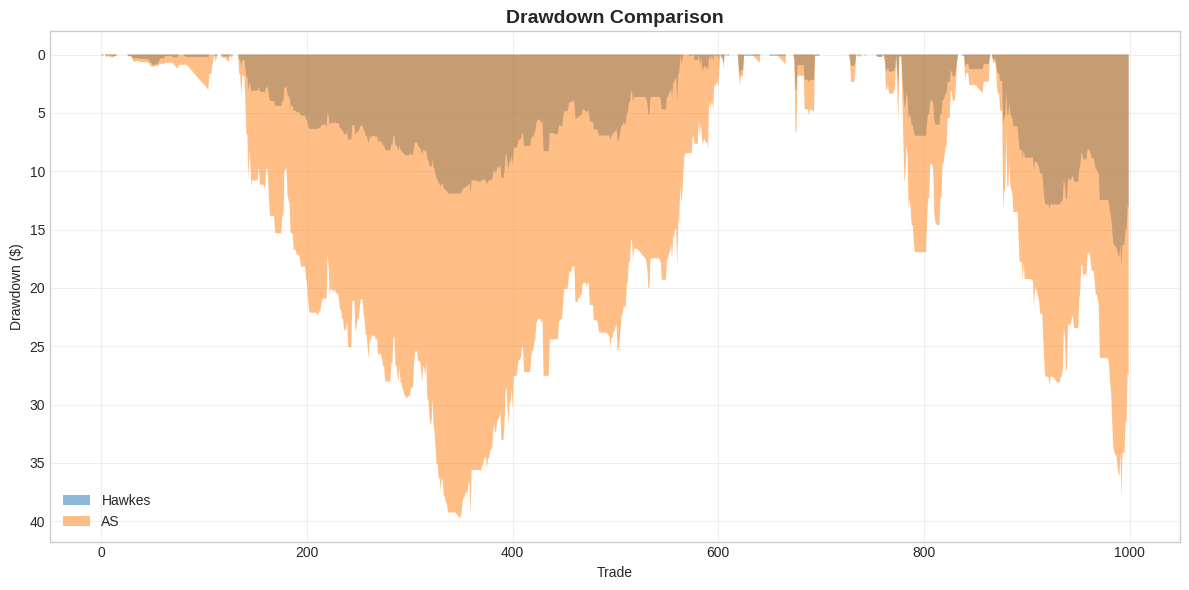

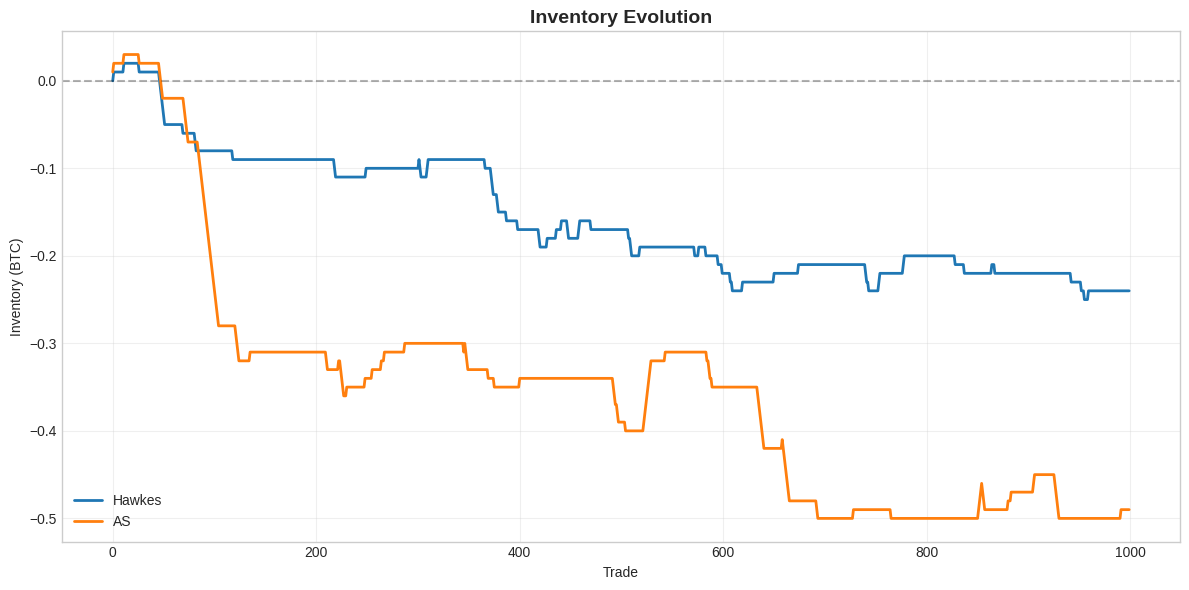

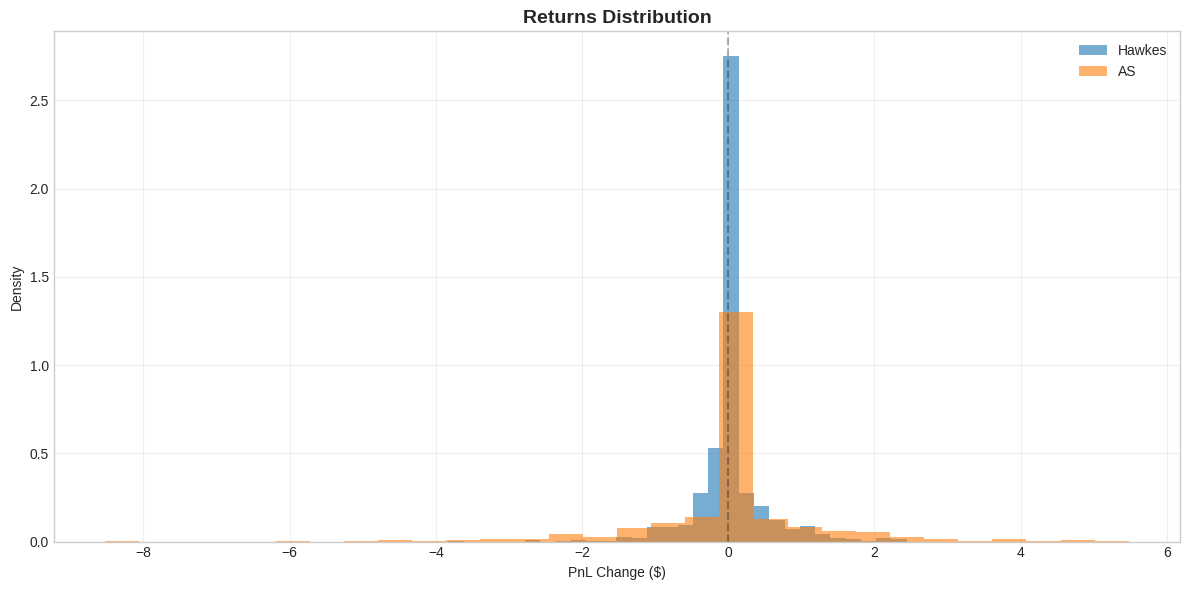

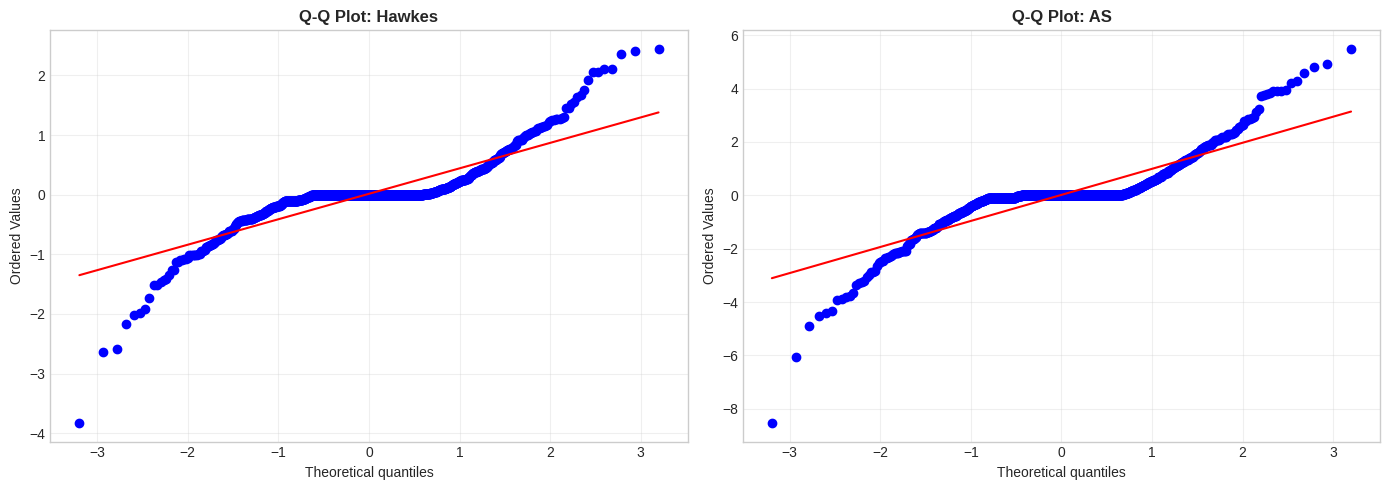

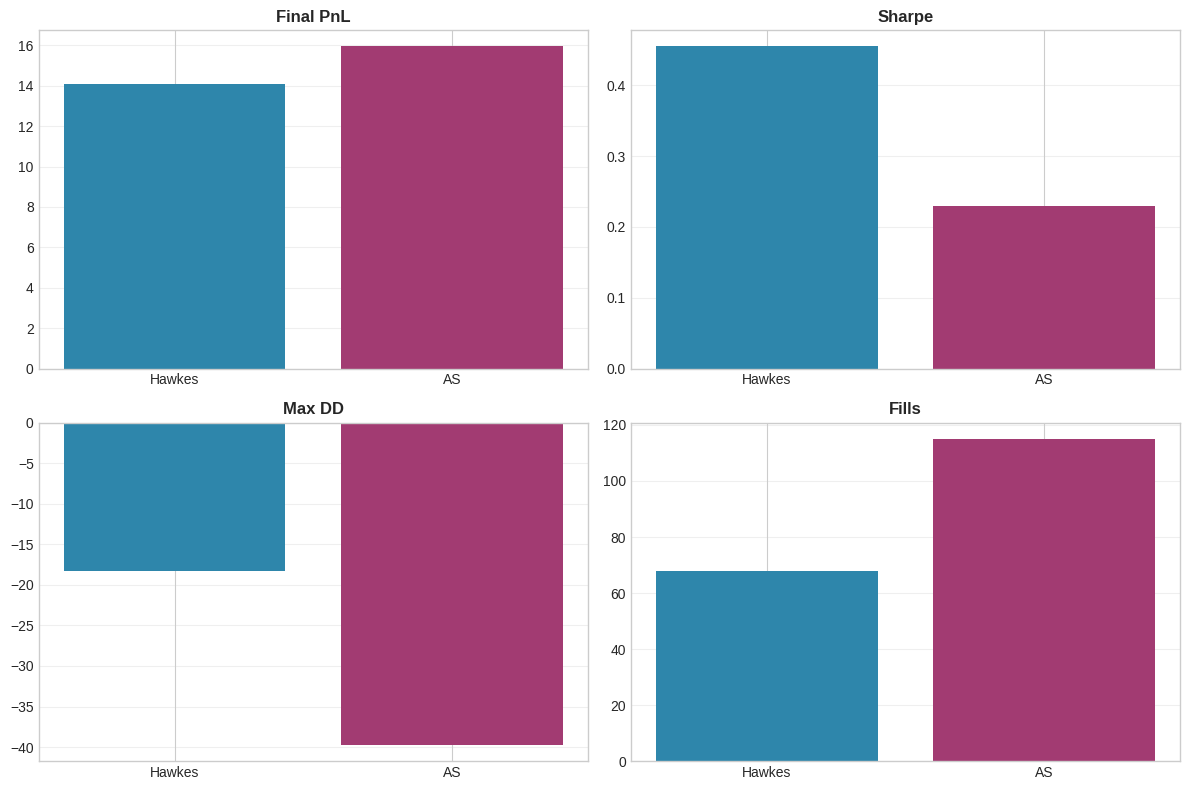

,Strategy,Shapiro Stat,p-value,Normal?
0,Hawkes,0.7562,0.0000,No
1,AS,0.7756,0.0000,No


In [10]:
plot_pnl_comparison(hawkes_results, as_results)
plot_drawdown_comparison(hawkes_results, as_results)
plot_inventory_evolution(hawkes_results, as_results)
plot_returns_distribution(hawkes_results, as_results)
plot_qq_plots(hawkes_results, as_results)
plot_performance_metrics(hawkes_results, as_results)

normality_results = compute_normality_tests(hawkes_results, as_results)
display(normality_results)